# Tutorial: FICO Explainable Machine Learning Challenge

In this tutorial, we use the dataset form the FICO Explainable Machine Learning Challenge: https://community.fico.com/s/explainable-machine-learning-challenge. The goal is to create a pipeline by combining a binning process and logistic regression to obtain an explainable model and compare it against a black-box model using Gradient Boosting Tree (GBT) as an estimator.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from optbinning import BinningProcess

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

Download the dataset from the link above and load it.

In [3]:
df = pd.read_csv("data/FICO_challenge/heloc_dataset_v1.csv", sep=",")

In [4]:
variable_names = list(df.columns[1:])

In [5]:
X = df[variable_names].values

Transform the categorical dichotomic target variable into numerical.

In [6]:
y = df.RiskPerformance.values
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(np.int)

#### Modeling

The data dictionary of this challenge includes three special values/codes:
    
* -9 No Bureau Record or No Investigation
* -8 No Usable/Valid Trades or Inquiries
* -7 Condition not Met (e.g. No Inquiries, No Delinquencies)

In [7]:
special_codes = [-9, -8, -7]

This challenge imposes monotonicity constraints with respect to the probability of a bad target for many of the variables. We apply these rules by passing the following dictionary of parameters for these variables involved.

In [8]:
binning_fit_params = {
    "ExternalRiskEstimate": {"monotonic_trend": "descending"},
    "MSinceOldestTradeOpen": {"monotonic_trend": "descending"},
    "MSinceMostRecentTradeOpen": {"monotonic_trend": "descending"},
    "AverageMInFile": {"monotonic_trend": "descending"},
    "NumSatisfactoryTrades": {"monotonic_trend": "descending"},
    "NumTrades60Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "NumTrades90Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "PercentTradesNeverDelq": {"monotonic_trend": "descending"},
    "MSinceMostRecentDelq": {"monotonic_trend": "descending"},
    "NumTradesOpeninLast12M": {"monotonic_trend": "ascending"},
    "MSinceMostRecentInqexcl7days": {"monotonic_trend": "descending"},
    "NumInqLast6M": {"monotonic_trend": "ascending"},
    "NumInqLast6Mexcl7days": {"monotonic_trend": "ascending"},
    "NetFractionRevolvingBurden": {"monotonic_trend": "ascending"},
    "NetFractionInstallBurden": {"monotonic_trend": "ascending"},
    "NumBank2NatlTradesWHighUtilization": {"monotonic_trend": "ascending"}
}

Instantiate a BinningProcess object class with variable names, special codes and dictionary of binning parameters. Create a explainable model pipeline and a black-blox pipeline.

In [9]:
binning_process = BinningProcess(variable_names, special_codes=special_codes,
                                 binning_fit_params=binning_fit_params)

In [10]:
clf1 = Pipeline(steps=[('binning_process', binning_process),
                      ('classifier', LogisticRegression(solver="lbfgs"))])

clf2 = LogisticRegression(solver="lbfgs")

clf3 = GradientBoostingClassifier()

Split dataset into train and test. Fit pipelines with training data, then generate classification reports to show the main classification metrics.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
clf1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('binning_process',
                 BinningProcess(binning_fit_params={'AverageMInFile': {'monotonic_trend': 'descending'},
                                                    'ExternalRiskEstimate': {'monotonic_trend': 'descending'},
                                                    'MSinceMostRecentDelq': {'monotonic_trend': 'descending'},
                                                    'MSinceMostRecentInqexcl7days': {'monotonic_trend': 'descending'},
                                                    'MSinceMostRecentTradeOpen': {'monotonic_tr...
                                                'NumInstallTradesWBalance',
                                                'NumBank2NatlTradesWHighUtilization',
                                                'PercentTradesWBalance'],
                                verbose=False)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
       

In [13]:
clf2.fit(X_train, y_train)

/home/gui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
clf3.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [15]:
y_pred = clf1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1004
           1       0.70      0.74      0.72      1088

    accuracy                           0.70      2092
   macro avg       0.70      0.70      0.70      2092
weighted avg       0.70      0.70      0.70      2092



In [16]:
y_pred = clf2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67      1004
           1       0.69      0.70      0.70      1088

    accuracy                           0.68      2092
   macro avg       0.68      0.68      0.68      2092
weighted avg       0.68      0.68      0.68      2092



In [17]:
y_pred = clf3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1004
           1       0.70      0.75      0.73      1088

    accuracy                           0.71      2092
   macro avg       0.71      0.70      0.70      2092
weighted avg       0.71      0.71      0.70      2092



Plot the Receiver Operating Characteristic (ROC) metric to evaluate and compare the classifiers' prediction.

In [18]:
probs = clf1.predict_proba(X_test)
preds = probs[:,1]
fpr1, tpr1, threshold = roc_curve(y_test, preds)
roc_auc1 = auc(fpr1, tpr1)

probs = clf2.predict_proba(X_test)
preds = probs[:,1]
fpr2, tpr2, threshold = roc_curve(y_test, preds)
roc_auc2 = auc(fpr2, tpr2)

probs = clf3.predict_proba(X_test)
preds = probs[:,1]
fpr3, tpr3, threshold = roc_curve(y_test, preds)
roc_auc3 = auc(fpr3, tpr3)

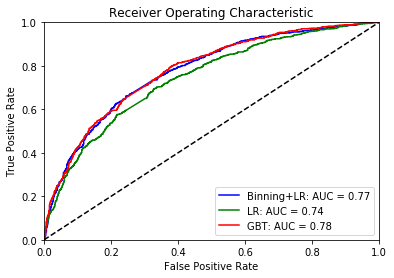

In [19]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Binning+LR: AUC = {0:.2f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, 'g', label='LR: AUC = {0:.2f}'.format(roc_auc2))
plt.plot(fpr3, tpr3, 'r', label='GBT: AUC = {0:.2f}'.format(roc_auc3))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The plot above shows the increment in terms of model performance after binning when the logistic estimator is chosen. Furthermore, a previous binning process might reduce numerical instability issues, as confirmed when fitting the classifier ``clf2``.

#### Binning process statistics

The binning process of the pipeline can be retrieved to show information about the problem and timing statistics.

In [20]:
binning_process.information(print_level=1)

optbinning (Version 0.2.0)
Copyright (c) 2020 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records            8367
    Number of variables            23
    Target type                binary

    Number of numerical            23
    Number of categorical           0
    Number of selected             23

  Time                         1.1891  sec



The ``summary`` method returns basic statistics for each binned variable.

In [21]:
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,gini,js,quality score
0,ExternalRiskEstimate,numerical,OPTIMAL,True,12,1.01837,0.534387,0.116638,0.0320893
1,MSinceOldestTradeOpen,numerical,OPTIMAL,True,11,0.252786,0.26474,0.0304826,0.0276948
2,MSinceMostRecentTradeOpen,numerical,OPTIMAL,True,6,0.0190861,0.0655971,0.00237738,0.000662449
3,AverageMInFile,numerical,OPTIMAL,True,10,0.319379,0.304157,0.0384577,0.132055
4,NumSatisfactoryTrades,numerical,OPTIMAL,True,10,0.126726,0.180888,0.0154239,0.00126273
5,NumTrades60Ever2DerogPubRec,numerical,OPTIMAL,True,4,0.17871,0.200184,0.0219149,0.314948
6,NumTrades90Ever2DerogPubRec,numerical,OPTIMAL,True,3,0.133485,0.155193,0.0163008,0.525357
7,PercentTradesNeverDelq,numerical,OPTIMAL,True,8,0.377803,0.316946,0.0454284,0.121685
8,MSinceMostRecentDelq,numerical,OPTIMAL,True,7,0.289526,0.272229,0.035246,0.305572
9,MaxDelq2PublicRecLast12M,numerical,OPTIMAL,True,3,0.33028,0.30167,0.0402498,0.971334


The ``get_binned_variable`` method serves to retrieve an optimal binning object, which can be analyzed in detail afterward.

In [22]:
optb = binning_process.get_binned_variable("NumBank2NatlTradesWHighUtilization")

In [23]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 0.50)",3416,0.408271,2184,1232,0.360656,0.662217,0.175281,0.021518
1,"[0.50, 1.50)",2015,0.240827,858,1157,0.574194,-0.209284,0.010461,0.001305
2,"[1.50, 2.50)",983,0.117485,345,638,0.649034,-0.525096,0.031309,0.003869
3,"[2.50, 3.50)",496,0.059281,137,359,0.723790,-0.873644,0.041802,0.005065
4,"[3.50, inf)",521,0.062268,139,382,0.733205,-0.921249,0.048466,0.005853
5,Special,936,0.111868,333,603,0.644231,-0.504077,0.027533,0.003406
6,Missing,0,0.000000,0,0,0.000000,0,0.000000,0.000000
Totals,,8367,1.000000,3996,4371,0.522409,,0.334853,0.041017


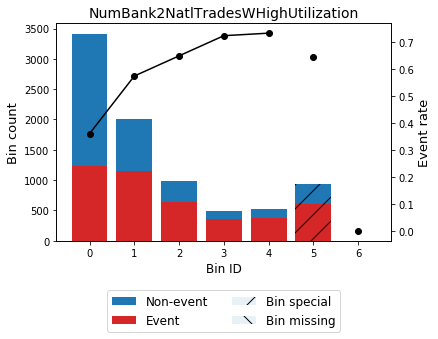

In [24]:
optb.binning_table.plot(metric="event_rate")

In [25]:
optb.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.30840174
    IV (Jeffrey)             0.33485338
    JS (Jensen-Shannon)      0.04101657
    Quality score            0.25673031

  Significance tests

     Bin A  Bin B  t-statistic       p-value       P[A > B]  P[B > A]
         0      1   234.556206  6.049946e-53  5.576352e-107  1.000000
         1      2    15.402738  8.686234e-05   7.665294e-06  0.999992
         2      3     8.386138  3.780934e-03   1.290940e-03  0.998709
         3      4     0.113909  7.357368e-01   3.678894e-01  0.632111

